# Random Acts of Pizza

This competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. Participants must create an algorithm capable of predicting which requests will garner a cheesy (but sincere!) act of kindness.

https://www.kaggle.com/c/random-acts-of-pizza

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.metrics import accuracy_score

In [2]:
# Put data in "Data" folder which is in the same location as this notebook
#os.getcwd()
#os.chdir('Data')
#os.getcwd()
os.chdir('C:\Users\zolotab\Desktop\w207-Machine-Learning-Final-Project-master\w207-Machine-Learning-Final-Project-master\Data')

In [3]:
# load data from json files to df
with open('train.json') as fin:
    trainjson = json.load(fin)

with open('test.json') as fin:
    testjson = json.load(fin)
    
df_train = pd.io.json.json_normalize(trainjson)
df_test = pd.io.json.json_normalize(testjson)

# Split data sets into train/dev/test

Since the test data does not indicate whether a pizza was revceived we split the trainer data to have a labeled test set.

In [35]:
# randomize and split data set into train, dev and test using 60/20/20 split
shuffle = np.random.permutation(np.arange(df_train.shape[0]))
df_train_data, df_train_labels = df_train.ix[shuffle, :], df_train.ix[shuffle, 'requester_received_pizza']
df_train_data, df_train_labels = df_train, df_train['requester_received_pizza']
# Set some variables to test, dev and training data
cutoff1 = int(df_train_labels.shape[0]*0.6)
cutoff2 = int(df_train_labels.shape[0]*0.8)
test_mini_data, test_mini_labels = df_train_data[cutoff2:], df_train_labels[cutoff2:]
dev_data, dev_labels = df_train_data[cutoff1:cutoff2], df_train_labels[cutoff1:cutoff2]
train_data, train_labels = df_train_data[:cutoff1], df_train_labels[:cutoff1]

print ('train data shape: ', train_data.shape)
print ('dev data shape:', dev_data.shape)
print ('test data shape:', test_mini_data.shape)

('train data shape: ', (2424, 32))
('dev data shape:', (808, 32))
('test data shape:', (808, 32))


# Tweak training set

In [82]:
df_train_nopizza = df_train[df_train['requester_received_pizza']==0]
df_train_pizza = df_train[df_train['requester_received_pizza']==1]
df_train2 = df_train_nopizza.iloc[:500,]
df_train2 = df_train2.append(df_train_pizza.iloc[:500,])

# build a test set with 50%/50% pizza/no pizza from the remaining data
df_test2 = df_train_pizza.iloc[500:,]
df_test2 = df_test2.append(df_train_nopizza.iloc[500:500+df_test2.shape[0],])

# build another test set with the remaining data
df_test3 = df_train_pizza.iloc[500:,]
df_test3 = df_test2.append(df_train_nopizza.iloc[500:,])

# randomize and split data set into train, dev and test using 60/20/20 split
shuffle = np.random.permutation(np.arange(df_train2.shape[0]))
#df_train_data, df_train_labels = df_train2.ix[shuffle, :], df_train2.ix[shuffle, 'requester_received_pizza']
df_train_data2, df_train_labels2 = df_train2, df_train2['requester_received_pizza']
# Set some variables to test, dev and training data
cutoff1 = int(df_train_labels2.shape[0]*0.8)
# cutoff2 = int(df_train_labels.shape[0]*0.8)
test_mini_data2, test_mini_labels2 = df_test2, df_test2['requester_received_pizza']
test_mini_data3, test_mini_labels3 = df_test3, df_test3['requester_received_pizza']
dev_data2, dev_labels2 = df_train_data[cutoff1:], df_train_labels[cutoff1:]
train_data2, train_labels2 = df_train_data2, df_train_labels2

print ('train data shape: ', train_data2.shape)
# print ('dev data shape:', dev_data.shape)
# print ('test data shape:', test_mini_data.shape)

('train data shape: ', (1000, 32))


# Modeling using Naive Count Vectorizer

# Vectorizing the text features

In [42]:
vectorizer = CountVectorizer()
vectorizer2 = CountVectorizer()
train_data_nlp = vectorizer.fit_transform(train_data['request_text_edit_aware'])
train_data_nlp2 = vectorizer2.fit_transform(train_data2['request_text_edit_aware'])
dev_data_nlp = vectorizer.transform(dev_data['request_text_edit_aware'])
dev_data_nlp2 = vectorizer2.transform(dev_data2['request_text_edit_aware'])
test_mini_data_nlp = vectorizer.transform(test_mini_data['request_text_edit_aware'])
test_mini_data_nlp2 = vectorizer2.transform(test_mini_data2['request_text_edit_aware'])
test_mini_data_nlp3 = vectorizer2.transform(test_mini_data3['request_text_edit_aware'])

In [43]:
print("Size of the vocabulary:")
print(train_data_nlp.shape[1])

Size of the vocabulary:
9515


# KNN Model

In [44]:
k_values = {"n_neighbors": range(1,10)}
knn_gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=k_values)
knn_gs.fit(dev_data_nlp2, dev_labels2)
print (knn_gs.best_params_)

{'n_neighbors': 8}


In [47]:
k_values = {"n_neighbors": range(1,10)}
knn_gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=k_values)
knn_gs.fit(dev_data_nlp, dev_labels)
print (knn_gs.best_params_)

{'n_neighbors': 8}


In [87]:
knn_clf_best = KNeighborsClassifier(n_neighbors=8)
knn_clf_best.fit(train_data_nlp, train_labels)
knn_clf_best_predicted = knn_clf_best.predict(test_mini_data_nlp)

knn_clf_best2 = KNeighborsClassifier(n_neighbors=8)
knn_clf_best2.fit(train_data_nlp2, train_labels2)
knn_clf_best_predicted2 = knn_clf_best2.predict(test_mini_data_nlp2)
knn_clf_best_predicted3 = knn_clf_best2.predict(test_mini_data_nlp3)

print "Original test KNN accuracy:"
print(accuracy_score(knn_clf_best_predicted2, test_mini_labels2) * 100)

print "50/50 test KNN accuracy:"
print(accuracy_score(knn_clf_best_predicted2, test_mini_labels2) * 100)

print "all test KNN accuracy:"
print(accuracy_score(knn_clf_best_predicted3, test_mini_labels3) * 100)

Original test KNN accuracy:
51.9230769231
50/50 test KNN accuracy:
51.9230769231
all test KNN accuracy:
77.843803056


In [88]:
# print confusion matrix to identify mistakes
print ("Original test Confusion matrix:")
print (confusion_matrix(test_mini_labels, knn_clf_best_predicted))

print ("50/50 test Confusion matrix:")
print (confusion_matrix(test_mini_labels2, knn_clf_best_predicted2))

print ("All test Confusion matrix:")
print (confusion_matrix(test_mini_labels3, knn_clf_best_predicted3))

Original test Confusion matrix:
[[609   3]
 [190   6]]
50/50 test Confusion matrix:
[[439  55]
 [420  74]]
All test Confusion matrix:
[[2677  363]
 [ 420   74]]


0.5128551420568227

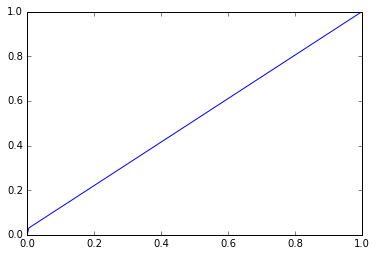

In [89]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, knn_clf_best_predicted)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

0.51923076923076916

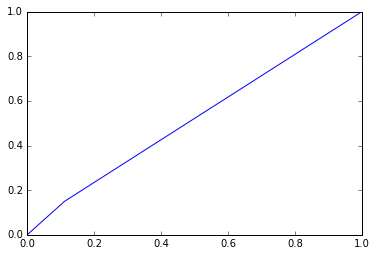

In [90]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels2, knn_clf_best_predicted2)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

0.5151948380566802

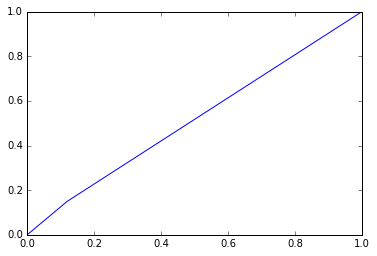

In [91]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels3, knn_clf_best_predicted3)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

# Multinomial Model

In [53]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp, dev_labels)
print (multi_gs.best_params_)

{'alpha': 1}


In [52]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp2, dev_labels2)
print (multi_gs.best_params_)

{'alpha': 10}


In [92]:
multi_clf_best = MultinomialNB(alpha=1)
multi_clf_best.fit(train_data_nlp, train_labels)
multi_clf_best_predicted = multi_clf_best.predict(test_mini_data_nlp)

multi_clf_best2 = MultinomialNB(alpha=1)
multi_clf_best2.fit(train_data_nlp2, train_labels2)
multi_clf_best_predicted2 = multi_clf_best2.predict(test_mini_data_nlp2)
multi_clf_best_predicted3 = multi_clf_best2.predict(test_mini_data_nlp3)

print ("Original test Multinomial accuracy:")
print(accuracy_score(multi_clf_best_predicted, test_mini_labels) * 100)

print ("50/50 test Multinomial accuracy:")
print(accuracy_score(multi_clf_best_predicted2, test_mini_labels2) * 100)

print ("All test Multinomial accuracy:")
print(accuracy_score(multi_clf_best_predicted3, test_mini_labels3) * 100)

Original test Multinomial accuracy:
72.7722772277
50/50 test Multinomial accuracy:
53.5425101215
All test Multinomial accuracy:
40.662139219


In [93]:
# print confusion matrix to identify mistakes
print ("Original test Confusion matrix:")
print (confusion_matrix(test_mini_labels, multi_clf_best_predicted))

print ("50/50 test Confusion matrix:")
print (confusion_matrix(test_mini_labels2, multi_clf_best_predicted2))

print ("All test Confusion matrix:")
print (confusion_matrix(test_mini_labels3, multi_clf_best_predicted3))

Original test Confusion matrix:
[[582  30]
 [190   6]]
50/50 test Confusion matrix:
[[169 325]
 [134 360]]
All test Confusion matrix:
[[1077 1963]
 [ 134  360]]


0.4907963185274109

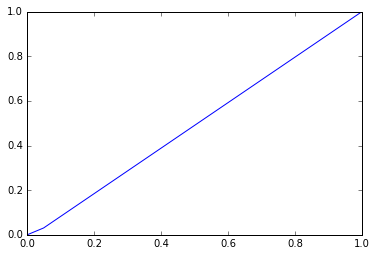

In [94]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, multi_clf_best_predicted)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

0.53542510121457487

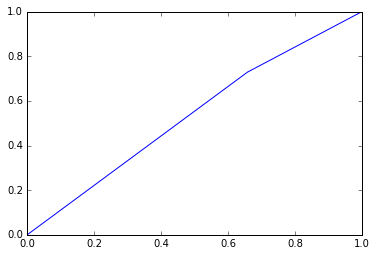

In [95]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels2, multi_clf_best_predicted2)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

0.54151062753036439

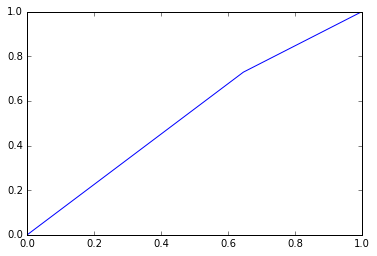

In [96]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels3, multi_clf_best_predicted3)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

# Logistic Model

In [61]:
# Logisitc modeling
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp, dev_labels)
print (log_gs.best_params_)

{'C': 0.001}


In [60]:
# Logisitc modeling
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp2, dev_labels2)
print (log_gs.best_params_)

{'C': 0.001}


In [97]:
log_clf_best = LogisticRegression(C=0.001)
log_clf_best.fit(train_data_nlp, train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data_nlp)

log_clf_best2 = LogisticRegression(C=0.001)
log_clf_best2.fit(train_data_nlp2, train_labels2)
log_clf_best_predicted2 = log_clf_best2.predict(test_mini_data_nlp2)
log_clf_best_predicted3 = log_clf_best2.predict(test_mini_data_nlp3)

print ("Original test Logistic accuracy:")
print(accuracy_score(log_clf_best_predicted2, test_mini_labels2) * 100)

print ("50/50 test Logistic accuracy:")
print(accuracy_score(log_clf_best_predicted2, test_mini_labels2) * 100)

print ("All test Logistic accuracy:")
print(accuracy_score(log_clf_best_predicted3, test_mini_labels3) * 100)

Original test Logistic accuracy:
52.7327935223
50/50 test Logistic accuracy:
52.7327935223
All test Logistic accuracy:
27.7306168647


In [98]:
# print confusion matrix to identify mistakes
print ("Original test Confusion matrix:")
print (confusion_matrix(test_mini_labels, log_clf_best_predicted))

print ("50/50 test Confusion matrix:")
print (confusion_matrix(test_mini_labels2, log_clf_best_predicted2))

print ("All test Confusion matrix:")
print (confusion_matrix(test_mini_labels3, log_clf_best_predicted3))

Original test Confusion matrix:
[[612   0]
 [196   0]]
50/50 test Confusion matrix:
[[ 87 407]
 [ 60 434]]
All test Confusion matrix:
[[ 546 2494]
 [  60  434]]


0.5

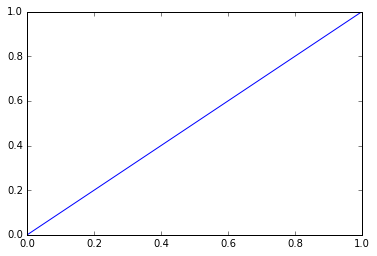

In [99]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, log_clf_best_predicted)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

0.52732793522267207

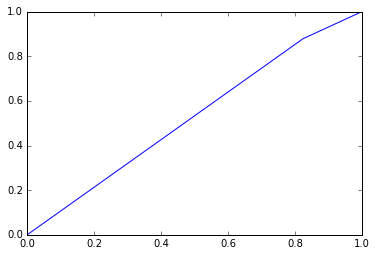

In [100]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels2, log_clf_best_predicted2)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

0.52907388663967614

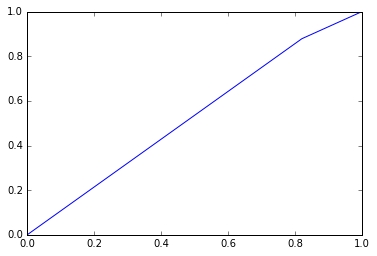

In [101]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels3, log_clf_best_predicted3)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

# Avdvanced Count Vectorizer

code from the Kaggle kernel

In [27]:
# Run Once
# Downloading corpus of stopwords and other functions

# import nltk
# nltk.download()

In [65]:
# Removing stopwords and punctuations

from string import punctuation
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

stopwords_en = set(stopwords.words('english'))

# Stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
# Combine the stopwords. Its a lot longer so I'm not printing it out...
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

In [66]:
# Removing stemming and lemmatization

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

# tagging part of speech so that lemmatization can be done
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

In [67]:
# updated preprocessor

def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]

In [69]:
vectorizer_adv = CountVectorizer(analyzer=preprocess_text)
train_data_nlp = vectorizer_adv.fit_transform(train_data['request_text_edit_aware'])
dev_data_nlp = vectorizer_adv.transform(dev_data['request_text_edit_aware'])
test_mini_data_nlp = vectorizer_adv.transform(test_mini_data['request_text_edit_aware'])

vectorizer_adv2 = CountVectorizer(analyzer=preprocess_text)
train_data_nlp2 = vectorizer_adv2.fit_transform(train_data2['request_text_edit_aware'])
dev_data_nlp2 = vectorizer_adv2.transform(dev_data2['request_text_edit_aware'])
test_mini_data_nlp2 = vectorizer_adv2.transform(test_mini_data2['request_text_edit_aware'])
test_mini_data_nlp3 = vectorizer_adv2.transform(test_mini_data3['request_text_edit_aware'])

In [70]:
print("Size of the vocabulary:")
print(train_data_nlp2.shape[1])

Size of the vocabulary:
5212


In [71]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp, dev_labels)
print (multi_gs.best_params_)

{'alpha': 1}


In [72]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp2, dev_labels2)
print (multi_gs.best_params_)

{'alpha': 1.5}


In [104]:
multi_clf_best = MultinomialNB(alpha=1)
multi_clf_best.fit(train_data_nlp, train_labels)
multi_clf_best_predicted = multi_clf_best.predict(test_mini_data_nlp)

multi_clf_best2 = MultinomialNB(alpha=1.5)
multi_clf_best2.fit(train_data_nlp2, train_labels2)
multi_clf_best_predicted2 = multi_clf_best2.predict(test_mini_data_nlp2)
multi_clf_best_predicted3 = multi_clf_best2.predict(test_mini_data_nlp3)

print ("Original test Multinomial accuracy:")
print(accuracy_score(multi_clf_best_predicted, test_mini_labels) * 100)

print ("50/50 test Multinomial accuracy:")
print(accuracy_score(multi_clf_best_predicted2, test_mini_labels2) * 100)

print ("All test Multinomial accuracy:")
print(accuracy_score(multi_clf_best_predicted3, test_mini_labels3) * 100)

Original test Multinomial accuracy:
72.7722772277
50/50 test Multinomial accuracy:
52.5303643725
All test Multinomial accuracy:
35.7102433503


In [105]:
# print confusion matrix to identify mistakes
print ("Original test Confusion matrix:")
print (confusion_matrix(test_mini_labels, multi_clf_best_predicted))

print ("50/50 test Confusion matrix:")
print (confusion_matrix(test_mini_labels2, multi_clf_best_predicted2))

print ("All test Confusion matrix:")
print (confusion_matrix(test_mini_labels3, multi_clf_best_predicted3))

Original test Confusion matrix:
[[582  30]
 [190   6]]
50/50 test Confusion matrix:
[[137 357]
 [112 382]]
All test Confusion matrix:
[[ 880 2160]
 [ 112  382]]


0.4907963185274109

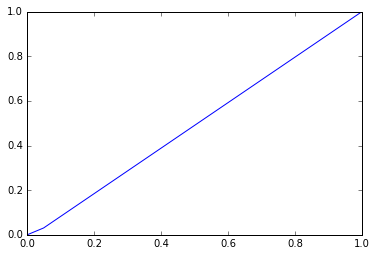

In [106]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, multi_clf_best_predicted)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

0.52530364372469629

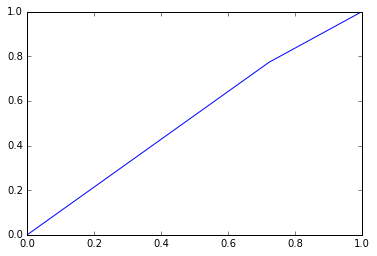

In [107]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels2, multi_clf_best_predicted2)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

0.53137651821862342

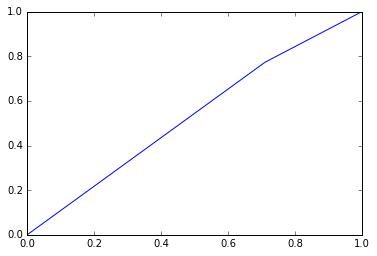

In [108]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels3, multi_clf_best_predicted3)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

In [76]:
# Logisitc modeling
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp, dev_labels)
print (log_gs.best_params_)

{'C': 0.001}


In [78]:
# Logisitc modeling
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp2, dev_labels2)
print (log_gs.best_params_)

{'C': 0.001}


In [109]:
log_clf_best = LogisticRegression(C=0.001)
log_clf_best.fit(train_data_nlp, train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data_nlp)

log_clf_best2 = LogisticRegression(C=0.001)
log_clf_best2.fit(train_data_nlp2, train_labels2)
log_clf_best_predicted2 = log_clf_best2.predict(test_mini_data_nlp2)
log_clf_best_predicted3 = log_clf_best2.predict(test_mini_data_nlp3)

print ("Original test Logistic accuracy:")
print(accuracy_score(log_clf_best_predicted2, test_mini_labels2) * 100)

print ("50/50 test Logistic accuracy:")
print(accuracy_score(log_clf_best_predicted2, test_mini_labels2) * 100)

print ("All test Logistic accuracy:")
print(accuracy_score(log_clf_best_predicted3, test_mini_labels3) * 100)

Original test Logistic accuracy:
52.7327935223
50/50 test Logistic accuracy:
52.7327935223
All test Logistic accuracy:
27.7306168647


In [110]:
# print confusion matrix to identify mistakes
print ("Original test Confusion matrix:")
print (confusion_matrix(test_mini_labels, log_clf_best_predicted))

print ("50/50 test Confusion matrix:")
print (confusion_matrix(test_mini_labels2, log_clf_best_predicted2))

print ("All test Confusion matrix:")
print (confusion_matrix(test_mini_labels3, log_clf_best_predicted3))

Original test Confusion matrix:
[[612   0]
 [196   0]]
50/50 test Confusion matrix:
[[ 87 407]
 [ 60 434]]
All test Confusion matrix:
[[ 546 2494]
 [  60  434]]


0.5

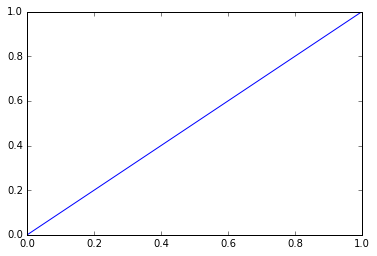

In [111]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, log_clf_best_predicted)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

0.52732793522267207

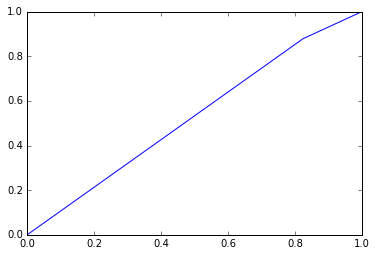

In [112]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels2, log_clf_best_predicted2)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)

0.52907388663967614

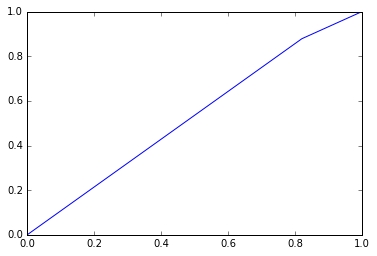

In [113]:
fpr, tpr, _ = metrics.roc_curve(test_mini_labels3, log_clf_best_predicted3)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.plot(fpr,tpr)

metrics.auc(fpr,tpr)